# Dispersive Materials

## Introduction / Setup

Here we show to to model dispersive materials in Tidy3D with an example showing transmission spectrum of a multilayer stack of slabs.

See on [github](https://github.com/flexcompute/tidy3d-notebooks/blob/main/Dispersion.ipynb), run on [colab](https://colab.research.google.com/github/flexcompute/tidy3d-notebooks/blob/main/Dispersion.ipynb), or just follow along with the output below.

In [1]:
# basic ipython configuration (reload source code and notebook plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline

# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3D import
!pip install -q --upgrade tidy3d

import tidy3d as td
from tidy3d import web

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, let us define some basic parameters.

In [2]:
# Wavelength and frequency range
lambda_range = (0.9, 1.1)
lam0 = np.sum(lambda_range)/2
freq_range = (td.constants.C_0/lambda_range[1], td.constants.C_0/lambda_range[0])
Nfreq = 133

# frequencies and wavelengths of monitor
monitor_freqs = np.linspace(freq_range[0], freq_range[1], Nfreq)
monitor_lambdas = td.constants.C_0 / monitor_freqs

# central frequency, frequency pulse width and total running time
freq0 = monitor_freqs[Nfreq // 2]
freqw  = 0.3 * (freq_range[1] - freq_range[0])
t_stop = 100 / freq0

# Thicknesses of slabs
t_slabs = [0.5, 0.2, 0.4, 0.3] # um

# Grid resolution (cells per um)
res = 10

# space between slabs and sources and PML
spacing = 1 * lambda_range[-1]

# simulation size
sim_size = Lx, Ly, Lz = (1.0, 10.0, 4*spacing + sum(t_slabs))

## Defining Materials (4 Ways)

We now create materials for each slab in 4 differt ways. The first three of those show various ways that the Tidy3D [Medium](https://simulation.cloud/docs/html/generated/tidy3d.Medium.html) class can be used to define custom materials. The last one is a direct import from our [material library](https://simulation.cloud/docs/html/generated/tidy3d.material_library.html#module-tidy3d.material_library).

1. Simple, lossless dielectric defined by a real, dispersionless refracive index (or permittivity).
2. Lossy material defined by real and imaginary part of the refractive index (\\(n\\) and \\(k\\)) at a given frequency or wavelength. Values are exact only at that frequency, so only good for narrow-band simulations.
3. Simple, lossless dispersive material (one-pole fitting) defined by the real part of the refractive index \\(n\\) and the dispersion \\(\mathrm{d}n/\mathrm{d}\lambda\\) at a given frequency or wavelength. The dispersion must be negative.
4. Dispersive material imported from our pre-defined library of materials.

More complicated dispersive materials can also be defined through their dispersive models (supported: Lorentz, Sellmeier, or Debye models).  See [here](https://simulation.cloud/docs/html/api.html#dispersive-models) for more details on defining materials this way if the model parameters are known.

In [3]:
# simple, lossless, dispersionless material (either epsilon or n)
mat1 = td.Medium(epsilon=4.0)

# lossy material with n & k values at a specified frequency or wavelength
mat2 = td.Medium(n=3.0, k=0.1, freq=freq0)

# lossless dispersive material with n & dn/dlambda at a specified frequency or wavelength
mat3 = td.Medium(n=2.0, dn=-0.02, freq=freq0)

# dispersive material from tidy3d library
mat4 = td.material_library.BK7()

# put all together
mat_slabs = [mat1, mat2, mat3, mat4]

## Create Simulation
Now we set everything else up (structures, sources, monitors, simulation) to run the example.

First, we define the multilayer stack structure.

In [4]:
slabs = []
slab_position = -Lz/2 + 2*spacing
for t, mat in zip(t_slabs, mat_slabs):
    slab = td.Box(
        center=(0, 0, slab_position + t/2),
        size=(td.inf, td.inf, t),
        material=mat,
    )
    slabs.append(slab)
    slab_position += t

We must now define the excitation conditions and field monitors. We will excite the slab using a normally incident (along z) planewave, polarized along the x direciton.

In [5]:
# Here we define the planewave source, placed just in advance (towards negative z) of the slab
source = td.PlaneWave(
    source_time = td.GaussianPulse(
        frequency = freq0,
        fwidth = freqw
    ),
    injection_axis='+z',
    position=-Lz/2 + spacing,
    polarization='x'
)

Here we define the field monitor, placed just past (towards positive z) of the stack.

In [6]:
# We are interested in measuring the transmitted flux, so we set it to be an oversized plane.
monitor = td.FreqMonitor(
    center = (0, 0, Lz/2 - spacing),
    size = (td.inf, td.inf, 0),
    freqs = monitor_freqs
)

Now it is time to define the simulation object.

In [7]:
sim = td.Simulation(
    center = (0, 0, 0),
    size = sim_size,
    mesh_step = 1/res,
    structures = slabs,
    sources = [source],
    monitors = [monitor],
    run_time = t_stop,
    pml_layers = (0, 0, 15)
)

Initializing simulation...
Mesh step (micron): [1.00e-01, 1.00e-01, 1.00e-01].
Simulation domain in number of grid points: [10, 100, 88].
Total number of grid points: 8.80e+04.
Total number of time steps: 1906.
Estimated data size (GB) of monitor monitor: 0.0064.


## Plot The Structure

Let's now plot the permittivity profile to confirm that the structure was defined correctly.

First we use `viz_mat_2D` to plot the materials only, which assigns a different color to each slab without knowledge of the material properties.

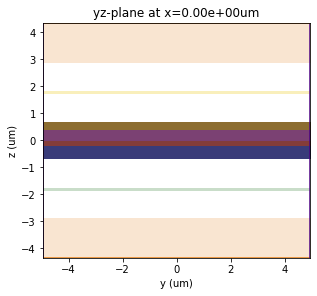

In [8]:
sim.viz_mat_2D(normal='x')
plt.show()

Next, we use `viz_eps_2D` to vizualize the permittivity of the stack. However, because the stack contains dispersive materials, we need to specify the `frequency` of interest as an argument to the plotting tool.  Here we show the permittivity at the lowest and highest frequences in the range of interest.  Note that in this case, the real part of the permittivity (being plotted) only changes slightly between the two frequencies on the dispersive material.  However, for other materials with more dispersion, the effect can be much more prominent.

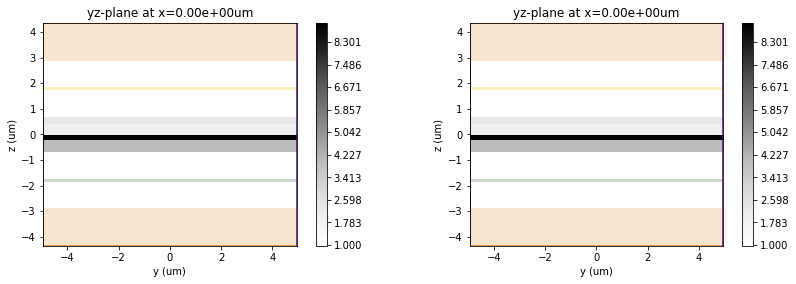

In [9]:
# plot the permittivity at a few frequencies
freqs_plot = (freq_range[0], freq_range[1])
fig, axes = plt.subplots(1, len(freqs_plot), tight_layout=True, figsize=(12, 4))
for ax, freq_plot in zip(axes, freqs_plot):
    sim.viz_eps_2D(normal='x', cbar=True, frequency=freq_plot, ax=ax)
plt.show()

We can also take a look at the source to make sure it's defined correctly over our frequency range of interst.

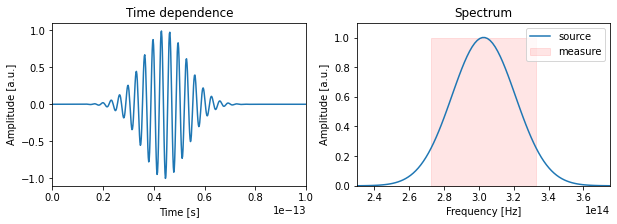

In [10]:
# Check probe and source
ax1, ax2 = sim.viz_source(source)
ax1.set_xlim(0, 1e-13)
# ax2.plot(freq_range, [1, 1])
ax2.fill_between(freq_range, [0,0], [1, 1], alpha=0.1, color='r')
ax2.legend(('source', 'measure'))
plt.show()

## Run the simulation

We will submit the simulation to run as a new project.

In [11]:
# Submit a project to the cluster
project = web.new_project(sim.export(), task_name='docs_dispersion')

Uploading the json file...


In [12]:
web.monitor_project(project['taskId'])

Project "docs_dispersion-9" status: success...    



## Postprocess and Plot

Once the simulation has completed, we can download the results and load them into the simulation object.

In [13]:
print('downloading data...')
web.download_results(project['taskId'], target_folder='out')
sim.load_results('out/monitor_data.hdf5')

downloading data...
Applying source normalization to all frequency monitors using source index 0.


Now, we compute the transmitted flux and plot the transmission spectrum.

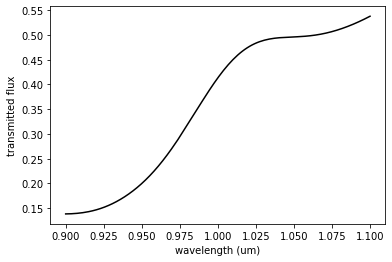

In [14]:
# Retrieve the power flux through the monitor plane.
transmission = sim.flux(monitor)
plt.plot(monitor_lambdas, transmission, color='k')
plt.xlabel('wavelength (um)')
plt.ylabel('transmitted flux')
plt.show()

To get power transmission, we need to do a normalizing run without any slab and divide by that result

In [15]:
sim_norm = td.Simulation(
    center = (0, 0, 0),
    size = sim_size,
    mesh_step = 1/res,
    structures = [],
    sources = [source],
    monitors = [monitor],
    run_time = t_stop,
    pml_layers = (0, 0, 15)
)
project = web.new_project(sim_norm.export(), task_name='docs_dispersion_norm')
web.monitor_project(project['taskId'])
print('downloading results...')
web.download_results(project['taskId'], target_folder='out')
sim_norm.load_results('out/monitor_data.hdf5')
transmission_norm = sim_norm.flux(monitor)

Initializing simulation...
Mesh step (micron): [1.00e-01, 1.00e-01, 1.00e-01].
Simulation domain in number of grid points: [10, 100, 88].
Total number of grid points: 8.80e+04.
Total number of time steps: 1906.
Estimated data size (GB) of monitor monitor: 0.0064.
Uploading the json file...
Project "docs_dispersion_norm-7" status: success...    

downloading results...
Applying source normalization to all frequency monitors using source index 0.


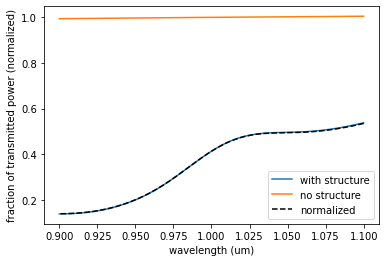

In [16]:
plt.plot(monitor_lambdas, transmission, label='with structure')
plt.plot(monitor_lambdas, transmission_norm, label='no structure')
plt.plot(monitor_lambdas, transmission / transmission_norm, 'k--', label='normalized')
plt.legend()
plt.xlabel('wavelength (um)')
plt.ylabel('fraction of transmitted power (normalized)')
plt.show()

We see that since the flux monitor already takes the source power into account, the normalizing run doens't affect the calculation much, but it is prudent to include for broadband calculations.